## SVM

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import preprocessing
import matplotlib.pyplot as plt
import timeit

In [2]:
from preprocessing import cargarDatasets
from preprocessing import prepararSet
from preprocessing import ingenieriaDeFeaturesSVM

In [3]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split,KFold, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score

In [4]:
from sklearn.svm import SVC

* Este metodo es un algortimo suvervisado en la cual busca un hiperplano que separae las clases de la mejor forma posible. 
* A su vez busca maximinar M (margen), el espacio entre los distintos puntos de las distintas clases. 
  Si se decea que los punos esten perfectamente separados tenemos un modelo hard margin, en donde el modelo no funciona con outliers y ruido. Si se le permite tener algo de rido y outliers entonces tenemos un modelo soft margin.

* En el caso en que no se encuentre el hiperplano, los puntos no son linealmente separables por lo que hay reccurir a una transformacion de datos en una nueva dimension. Como es costoso se utilizan kernes que hace que se piense que esta en otro dimension. Estos kernel puede sen lineal, polinomial, radial, etc.

## Carga y preprosesamiento de datos 

In [5]:
train_df,final_df = cargarDatasets()
train_df = prepararSet(train_df)


Una vez que tenemos cargados el set de entrenamiento vamos a ir aplicando distintos preprocesamientos

svm es sensible a la escala y distribucion de datos, es por eso que normalizamos las variables.

In [6]:
X,y,df,y_encoder = ingenieriaDeFeaturesSVM(train_df)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=117, test_size=0.1, stratify=y)

## Busca de hiperparaemtros

los hiperparametros a tener en cuenta van a ser c y el kernel 
* c: es la resistencia al ruido, a mayor c se tiene un modelo hard margin y a menor c se tiene un modelo soft margin.
* kernel: es una funcion que nos permite tener dimensiones mayores sin tener que convertir los datos.     

In [8]:
parametros_lineal = [ {'C': [1,2,3] , 'kernel': ['linear']}]

In [9]:
parametros_radial = [ {'C': [0.5,1,2,3], 'gamma': [0.0000001,0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100], 'kernel': ['rbf']}]

In [10]:
parametro_polinomial = [{'C': [1,2,3], 'gamma': [0.0000001,0.0001,0.01, 0.1, 1], 'degree':[3,10,100,500]}]

In [11]:
svm = SVC(probability = True)
lineal = RandomizedSearchCV(
    svm, parametros_lineal, scoring='roc_auc', n_jobs=-1, cv=2, return_train_score=True, n_iter = 8, verbose = 99
)

In [12]:
resultado1 = lineal.fit(X_train, y_train)

Fitting 2 folds for each of 3 candidates, totalling 6 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


/home/sol/.local/lib/python3.8/site-packages/sklearn/model_selection/_search.py:278: UserWarning: The total space of parameters 3 is smaller than n_iter=8. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done   2 out of   6 | elapsed:  2.4min remaining:  4.7min
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:  2.8min remaining:  2.8min
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:  2.8min remaining:  1.4min
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:  4.6min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:  4.6min finished


In [13]:
print('mejor score: %s' % resultado1.best_score_)
print('mejores hiperparametros %s' % resultado1.best_params_)
   

mejor score: 0.8813722378785952
mejores hiperparametros {'kernel': 'linear', 'C': 3}


Pruebo con radial

In [14]:
svm = SVC(probability = True)
radial = RandomizedSearchCV(
    svm, parametros_radial, scoring='roc_auc', n_jobs=-1, cv=2, return_train_score=True, n_iter = 8, verbose = 99
)

In [15]:
resultado2 = radial.fit(X_train, y_train)

Fitting 2 folds for each of 8 candidates, totalling 16 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  7.2min
[Parallel(n_jobs=-1)]: Done  10 out of  16 | elapsed:  7.3min remaining:  4.4min
[Parallel(n_jobs=-1)]: Done  11 out of  16 | elapsed:  7.7min remaining:  3.5min
[Parallel(n_jobs=-1)]: Done  12 out of  16 | elapsed:  7.8min remaining:  2.6min
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:  9.8min r

In [16]:
print('mejor score: %s' % resultado2.best_score_)
print('mejores hiperparametros %s' % resultado2.best_params_)

mejor score: 0.881741226937123
mejores hiperparametros {'kernel': 'rbf', 'gamma': 0.001, 'C': 3}


Pruebo con polonimial

In [17]:
svm = SVC(probability = True)
poly = RandomizedSearchCV(
    svm, parametro_polinomial, scoring='roc_auc', n_jobs=-1, cv=3, return_train_score=True, n_iter = 8, verbose = 99
)

In [18]:
resultado3 = poly.fit(X_train, y_train)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  7.5min
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:  7.9min
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:  8.6min
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:  8.8min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed: 11.6min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed: 12.0min
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed: 12.4min
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed: 12.7min
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed: 16.2min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed: 16.4

In [19]:
print('mejor score: %s' % resultado3.best_score_)
print('mejores hiperparametros %s' % resultado3.best_params_)

mejor score: 0.8776762962876234
mejores hiperparametros {'gamma': 1e-07, 'degree': 100, 'C': 3}


vemos que el mejor score lo obtuvimos con el kernel lineal. Ahora entrenamos.

# Entrenamos Modelo

In [20]:
svm = SVC(kernel='linear', C=1, probability=True)
svm.fit(X_train, y_train)

SVC(C=1, kernel='linear', probability=True)

# Analisis de Metricas 

In [21]:
y_pred = svm.predict(X_test)

# Precision, Recall, F1- score, Accuracy

In [22]:
print(classification_report(y_test, y_pred, target_names=['tiene bajo poder adqusitivo','tiene alto poder adquisitivo']))

                              precision    recall  f1-score   support

 tiene bajo poder adqusitivo       0.87      0.93      0.89      2473
tiene alto poder adquisitivo       0.70      0.55      0.62       784

                    accuracy                           0.83      3257
                   macro avg       0.78      0.74      0.76      3257
                weighted avg       0.83      0.83      0.83      3257



# Matriz de confuncion

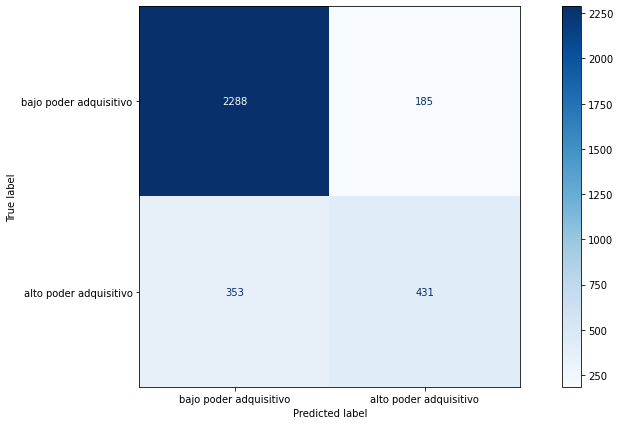

In [23]:
from sklearn.metrics import plot_confusion_matrix

fig, ax = plt.subplots(figsize=(15, 7))
plt.grid(False)
plot_confusion_matrix(
    svm, X_test, y_test, cmap=plt.cm.Blues, display_labels=['bajo poder adquisitivo', 'alto poder adquisitivo'], ax=ax
)
plt.show()

# Auc roc curve

In [24]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, plot_roc_curve

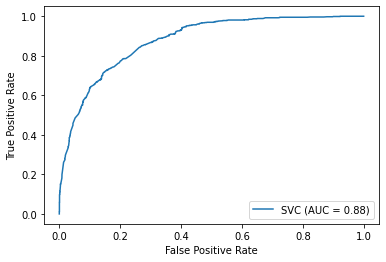

In [25]:
plot_roc_curve(svm,X_test,y_test,response_method='predict_proba')
plt.show()

# Prediccion sobre el data ser de HoldOut 

In [26]:
from preprocessing import prepararSetDeHoldOutSvm
from preprocessing import prepararSet

In [27]:
final_df_copy = prepararSet(final_df)

In [30]:
final_df_copy = prepararSetDeHoldOutSvm(final_df_copy)

In [31]:
ho_prediction = svm.predict(final_df_copy)
final_df['tiene_alto_valor_adquisitivo'] = ho_prediction

final_df.to_csv('predicciones/svm.csv')